# Interactive Jupyter notebook for hydrographic ocean data exploration, retrieval and visualization via the Argovis API


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Interactive-Jupyter-notebook-for-hydrographic-ocean-data-exploration,-retrieval-and-visualization-via-the-Argovis-API" data-toc-modified-id="Interactive-Jupyter-notebook-for-hydrographic-ocean-data-exploration,-retrieval-and-visualization-via-the-Argovis-API-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Interactive Jupyter notebook for hydrographic ocean data exploration, retrieval and visualization via the Argovis API</a></span><ul class="toc-item"><li><span><a href="#Authors-" data-toc-modified-id="Authors--1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Authors <a class="anchor" id="Authors"></a></a></span></li><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Technical-contributions" data-toc-modified-id="Technical-contributions-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Technical contributions</a></span></li><li><span><a href="#Methodology" data-toc-modified-id="Methodology-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Methodology</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Results</a></span></li><li><span><a href="#Funding" data-toc-modified-id="Funding-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Funding</a></span></li><li><span><a href="#Keywords" data-toc-modified-id="Keywords-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Keywords</a></span></li><li><span><a href="#Citation" data-toc-modified-id="Citation-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Citation</a></span></li><li><span><a href="#Work-In-Progress---improvements" data-toc-modified-id="Work-In-Progress---improvements-1.9"><span class="toc-item-num">1.9&nbsp;&nbsp;</span>Work In Progress - improvements</a></span></li><li><span><a href="#Acknowledgements" data-toc-modified-id="Acknowledgements-1.10"><span class="toc-item-num">1.10&nbsp;&nbsp;</span>Acknowledgements</a></span></li></ul></li><li><span><a href="#Setup" data-toc-modified-id="Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup</a></span><ul class="toc-item"><li><span><a href="#Library-import" data-toc-modified-id="Library-import-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Library import</a></span></li></ul></li><li><span><a href="#Data-processing" data-toc-modified-id="Data-processing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data processing</a></span><ul class="toc-item"><li><span><a href="#Collecting-Data" data-toc-modified-id="Collecting-Data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Collecting Data</a></span></li><li><span><a href="#Formatting-Data" data-toc-modified-id="Formatting-Data-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Formatting Data</a></span></li></ul></li><li><span><a href="#Data-visualizations" data-toc-modified-id="Data-visualizations-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data visualizations</a></span><ul class="toc-item"><li><span><a href="#Plotting-metadata-on-a-map" data-toc-modified-id="Plotting-metadata-on-a-map-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Plotting metadata on a map</a></span></li><li><span><a href="#Generate-property-plots" data-toc-modified-id="Generate-property-plots-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Generate property plots</a></span></li></ul></li><li><span><a href="#Learning-Objectives" data-toc-modified-id="Learning-Objectives-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Learning Objectives</a></span></li><li><span><a href="#References" data-toc-modified-id="References-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>References</a></span></li></ul></div>

## Authors <a class="anchor" id=Authors></a>
List authors, their current affiliations,  up-to-date contact information, and ORCID if available. Add as many author lines as you need. 

- Author1 = {"name": "Susanna Anil", "affiliation": "University of California San Diego", "email": "sanil@ucsd.edu", "orcid":}
- Author2 = {"name": "Steve Diggs", "affiliation": "Scripps Institution of Oceanography, University of California San Diego", "email": sdiggs@ucsd.edu,"orcid": "orcid.org/0000-0003-3814-6104"}
- Author3 = {"name": "Sarah Purkey", "affiliation": "CASPO, Scripps Institution of Oceanography, La Jolla, CA, United States.", "email": "spurkey@ucsd.edu", "orcid": "orcid.org/0000-0002-1893-6224"}
- Author4 = {"name": "Donata Giglio", "affiliation": "Department of Atmospheric and Oceanic Sciences, University of Colorado Boulder, Boulder, CO, United States", "email": "donata.giglio@colorado.edu", "orcid": "orcid.org/0000-0002-3738-4293"}
- Author5 = {"name": "Megan Scanderbeg", "affiliation": "CASPO, Scripps Institution of Oceanography, La Jolla, CA, United States.", "email": "mscanderbeg@ucsd.edu", "orcid": "orcid.org/0000-0002-0398-7272"}
- Author6 = {"name": "Tyler Tucker", "affiliation": "Department of Atmospheric and Oceanic Sciences, University of Colorado Boulder, Boulder, CO, United States", "email": "tytu6322@colorado.edu", "orcid": "orcid.org/0000-0002-0560-9777"}

## Purpose
[Argovis](https://argovis.colorado.edu/) allows access to a curated database of Argo profiles via API (Tucker et al. 2020). The interface allows users to visualize temperature, salinity and biogeochemical data (or BGC) by location on a browser. This notebook demonstrates how to use the Argovis API to visualize salinity and temperature property distributions below the ocean surface. This educational template is designed for an undergraduate or graduate student taking their first class in oceanography. Basic oceanographic concepts are introduced, in line with the most introductory classes, as well as introducing students to Argo data and teaching some basic programming concepts.

- The first half of the notebook goes over how to query data with user-defined parameters and use the API to retrieve data
- The second part of the notebook will allow users to plot the location of the data on a map and plot property plots to gain insights into observed water masses

The future versions of this notebook will continue to extend the capabilities of the Argovis API to generate learnable material with vast applications. Whether you’re a first-time programmer or a new oceanography student, this notebook will guide you through the basic but formative steps to studying the ocean. 



## Technical contributions
- Leverage the existing [Argovis API](https://github.com/tylertucker202/EC-Argovis-API-Demo) functions  to compile, query and plot global data from the Argovis interface. 
- Teach fundamental concepts about interior ocean properties 
- Introduce functions and interactive widgets to plot property-property plots of ocean profiles to grow familiar with ocean metrics


## Methodology
The notebook utilizes basic python packages for data manipulation and visualization: pandas, numpy, matplotlib, and cartopy. 
This notebook features a tutorial on how to use the Argovis API and make scientific inferences from subsurface ocean property profile plots. It leads with learning objectives, followed by an execution of the code and ends with some insightful questions to promote learning. We implement a few functions from the notebook by Tucker at al. 2020, specifically `get_selection_profiles` and `parse_into_df` to query and compile data with the API. The function `plot_pmesh` was modified to plot the selection profiles onto a global map for spatial reference. 

## Results
The primary objective of this notebook is to serve as a learning tool for undergraduate and graduate students in introductory oceanography classes. Once we add more activites to this notebook to cover the fundamentals of reading ocean data, it will be featured in oceanography classes starting in Fall 2021 at University of California, San Diego and University of Colorado Boulder. 

## Funding
- Award1 = {"agency": "US National Science Foundation", "award_code": "2026776", "award_URL":  [http://www.nsf.gov/awardsearch/showAward?AWD_ID=2026776&HistoricalAwards=false](http://www.nsf.gov/awardsearch/showAward?AWD_ID=2026776&HistoricalAwards=false)}
- Award2 = {"agency": "US National Science Foundation", "award_code": "1928305", "award_URL": 
 [https://www.nsf.gov/awardsearch/showAward?AWD_ID=1928305&HistoricalAwards=false](https://www.nsf.gov/awardsearch/showAward?AWD_ID=1928305&HistoricalAwards=false)}
- Award3 = {"agency": " NOAA Cooperative Agreement Grant ", "award_code": "NA16SEC4810008", "award_URL":    [https://govtribe.com/award/federal-grant-award/cooperative-agreement-na16sec4810008](https://govtribe.com/award/federal-grant-award/cooperative-agreement-na16sec4810008)}


## Keywords
keywords=["Argovis", "hydrographic data", "profiling floats", "exploring ocean data", "in-situ ocean observations"]

## Citation
Anil, S., Diggs, S., Purkey, S., Giglio, D., Scanderbeg, M., Tucker, T. (2021). Interactive Jupyter notebook for hydrographic ocean data exploration, retrieval and visualization via the Argovis API. Jupyter Notebook [github url] [a DOI will be assigned after review]

## Work In Progress - improvements
Notable TODOs:
- Including more shapes for possible regions of interest 
- Including contour plots by time, latitude and longitude
- Further development of educational materials in coordination with Professors Purkey and Giglio

## Acknowledgements 
Thank you Earthcube for the opportunity. 

These data were collected and made freely available by the [International Argo Program](https://argo.ucsd.edu) and the national programs that contribute to it. The Argo Program is part of the [Global Ocean Observing System](https://www.ocean-ops.org). 

# Setup

## Library import
These are some fundamental libraries that are very common in data analysis and visualization functions. Included below is a short description of each library and a link to its documentation for further reading. 
- `numpy`: a fundamental package for scientific computing
https://numpy.org/doc/stable/user/whatisnumpy.html
- `pandas`: package with various data anlysis methods and easy-to-use dataframes 
https://pandas.pydata.org/docs/#module-pandas 
- `datetime`: module for manipulating dates and times 
https://docs.python.org/3/library/datetime.html
- `matplotlib`: package with various visualization methods
https://matplotlib.org/
- `cartopy`: package designed for analyzing and visualizing geospatial data
https://scitools.org.uk/cartopy/docs/latest/
- `ipywidgets`: implement interactive widgets with Jupyter notebooks
https://ipywidgets.readthedocs.io/en/latest/

In [1]:
#data processing
import requests
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

#data visualization
import matplotlib.pylab as plt
%matplotlib inline

#used for map projections
import cartopy.crs as ccrs

#widgets for user interaction
import ipywidgets as widgets

import warnings
warnings.filterwarnings('ignore')


# Data processing
The following functions are from the Argovis API notebook. Reference [this github repository](https://github.com/earthcube2020/ec20_tucker_etal) for further methods on data querying based on space/time selection. 

## Collecting Data
To query results from a specific space and time selection, the following Argo API functions will format your specifications into a URL that requests the data from the Argovis website and return a file with all of the data. 

The parameters that will be adjusted:
- `startDate`: string formatted as 'YYYY-MM-DD'
- `endDate`: string formatted as 'YYYY-MM-DD'
- `shape`: list of lists containing [lon, lat] coordinates
- `presRange`: a string of a list formatted as '[minimum pres,maximum pres]' (no spaces)
- `printUrl`: boolean (True/False option) that prints url output if equal to True

In [2]:
def get_selection_profiles(startDate, endDate, shape, presRange=None, printUrl=True):
    url = 'https://argovis.colorado.edu/selection/profiles'
    url += '?startDate={}'.format(startDate)
    url += '&endDate={}'.format(endDate)
    url += '&shape={}'.format(shape)
    if presRange:
        pressRangeQuery = '&presRange=' + presRange
        url += pressRangeQuery                         #compose URL with selection parameters
    if printUrl:
        print(url)
    resp = requests.get(url)
    # Consider any status other than 2xx an error
    if not resp.status_code // 100 == 2:
        return "Error: Unexpected response {}".format(resp)
    selectionProfiles = resp.json()
    return selectionProfiles

## Formatting Data
In `parse_into_df()` the argument `profiles` will be the URL from the previous function. The given data file will be be cleaned and formatted into a dataframe with the following columns: 
- Pressure [dbar]
- Temperature [Celsius] 
- Salinity [psu]
- Cycle Number
- Profile ID
- Latitude
- Longitude
- Date of input

In [3]:
def parse_into_df(profiles):
    meas_keys = profiles[0]['measurements'][0].keys()
    df = pd.DataFrame(columns=meas_keys)      #create dataframe for profiles 
    for profile in profiles:                  #specify columns for profile measurements
        profileDf = pd.DataFrame(profile['measurements'])    
        profileDf['cycle_number'] = profile['cycle_number']
        profileDf['profile_id'] = profile['_id']
        profileDf['lat'] = profile['lat']
        profileDf['lon'] = profile['lon']
        profileDf['date'] = profile['date']
        df = pd.concat([df, profileDf], sort=False)
    return df

**Try it yourself:** Adjust the first four variables (shape, startDate, endDate, presRange) to query results from Argo data. This cell will return the URL to a page containing all of the metadata within your specified parameters.   

In [4]:
#replace the following variables 
shape = [[[-144.84375,36.031332],[-136.038755,36.210925],[-127.265625,35.746512],[-128.144531,22.755921],[-136.543795,24.835311],[-145.195313,26.431228],[-144.84375,36.031332]]]
startDate='2021-4-10'
endDate='2021-6-29'
presRange='[0,500]'

# do not change code below
strShape = str(shape).replace(' ', '')
selectionProfiles = get_selection_profiles(startDate, endDate, strShape, presRange)

https://argovis.colorado.edu/selection/profiles?startDate=2021-4-10&endDate=2021-6-29&shape=[[[-144.84375,36.031332],[-136.038755,36.210925],[-127.265625,35.746512],[-128.144531,22.755921],[-136.543795,24.835311],[-145.195313,26.431228],[-144.84375,36.031332]]]&presRange=[0,500]


Here we are checking that our data file is not empty then calling `parse_into_df` to create a data frame out of the values found in the file. Then to complete the data cleaning process, we replace all occurences of -999, which is a placeholder value for null or missing values in the data, with the null keyword: NaN. This is crucial to the data cleaning step because we do not want these large negative values to affect our data analysis and/or skew our visualizations. 

In [10]:
if len(selectionProfiles) > 0:                            
    selectionDf = parse_into_df(selectionProfiles)
selectionDf.replace(-999, np.nan, inplace=True)           #replace -999 with NaN

Below is all of the data cleaned and formatted properly. 

In [6]:
selectionDf = parse_into_df(selectionProfiles)
selectionDf

,psal,pres,temp,cycle_number,profile_id,lat,lon,date
0,35.123,3.97,21.583,42.0,5906178_42,26.453,-140.787,2021-06-08T11:55:05.001Z
1,35.123,5.87,21.585,42.0,5906178_42,26.453,-140.787,2021-06-08T11:55:05.001Z
2,35.123,7.87,21.581,42.0,5906178_42,26.453,-140.787,2021-06-08T11:55:05.001Z
3,35.123,9.87,21.582,42.0,5906178_42,26.453,-140.787,2021-06-08T11:55:05.001Z
4,35.123,11.87,21.588,42.0,5906178_42,26.453,-140.787,2021-06-08T11:55:05.001Z
...,...,...,...,...,...,...,...,...
243,NaN,490.65,6.066,311.0,5905057_311,25.673,-128.275,2021-04-10T19:10:59.000Z
244,NaN,492.65,5.973,311.0,5905057_311,25.673,-128.275,2021-04-10T19:10:59.000Z
245,NaN,494.65,5.918,311.0,5905057_311,25.673,-128.275,2021-04-10T19:10:59.000Z
246,NaN,496.65,5.903,311.0,5905057_311,25.673,-128.275,2021-04-10T19:10:59.000Z


# Data visualizations

## Plotting metadata on a map
This function will take the coordinates from the profiles in your selection dataframe and plot them onto a map. Use this to reference how many floats are in your selection and predict what kind of temperature and salinity values you might see in the next step.

**Try it yourself:** Explore the functionality of the previous methods by experimenting with your selection parameters. 

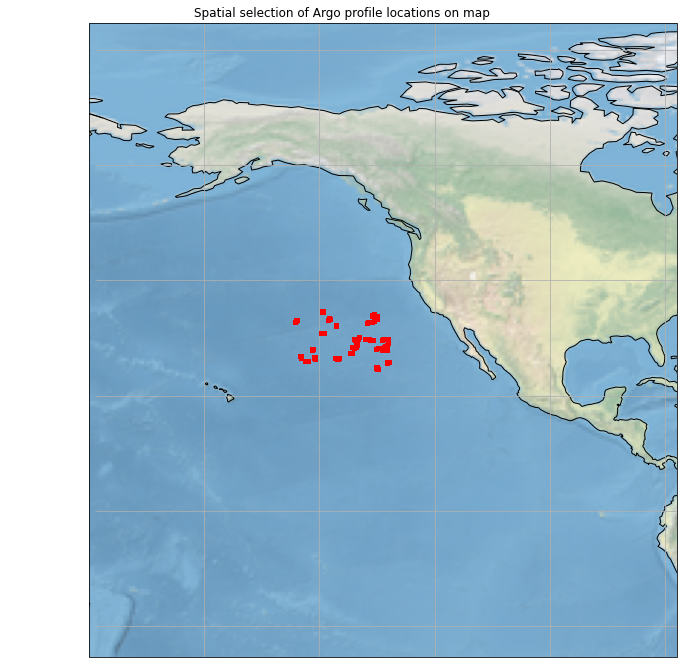

In [7]:
def plot_pmesh(figsize=(12,12), shrinkcbar=.1, delta_lon=50, delta_lat=50, \
               map_proj=ccrs.PlateCarree(), xlims=None):
    df = selectionDf
    fig = plt.figure(figsize=figsize)
    
    #collect lon, lat values to create coordinates
    x = df['lon'].values                   
    y = df['lat'].values
    points = map_proj.transform_points(ccrs.Geodetic(), x, y)
    x = points[:, 0]
    y = points[:, 1]
    
    #plot coordinates
    map_proj._threshold /= 100
    ax = plt.axes(projection=map_proj, xlabel='long', ylabel='lats')
    ax.set_global()
    plt.title('Spatial selection of Argo profile locations on map')
    sct = plt.scatter(x, y, c='r', s=15,zorder=3) 
    
    #specify boundaries for map plot
    if not xlims:
        xlims = [df['lon'].max() + delta_lon, df['lon'].min()- delta_lon]
    ax.set_xlim(min(xlims), max(xlims))
    ax.set_ylim(min(df['lat']) - delta_lat, max(df['lat']) + delta_lat)
    
    ax.coastlines(zorder=1)
    ax.stock_img()
    ax.gridlines()
    return fig

# run function 
map_viz = plot_pmesh()

## Generate property plots
To visualize relationships between profile measurements, we can plot features in a property plot. Each line is specified by `z_col` which can be any of the following: 
- `profile_id`
- `date`

In [23]:
#options for drop-drown menus
x = [('Temperature', 'temp'),('Pressure', 'pres'),('Salinity', 'psal')]
y = [('Pressure', 'pres'),('Temperature', 'temp'),('Salinity', 'psal')]
z = [('Profile ID', 'profile_id'),('Date', 'date')]

#initialize widgets
x_drop = widgets.Dropdown(options=x, val='Temperature', description='X-variable', disabled=False)
y_drop = widgets.Dropdown(options=y, val='Pressure', description='Y-variable', disabled=False)
z_drop = widgets.Dropdown(options=z, val='Profile ID', description='Z-variable', disabled=False)
widgets.VBox([x_drop, y_drop, z_drop])

unit_dict = {'pres':'Pressure [dbar]', 'temp': 'Temperature [Celsius]', 'psal':'Salinity [psu]'}
def property_plot_selection(x_col, y_col, z_col):
    print('Recalculating....')
    fig, ax = plt.subplots()
    
    #group lines by z-variable
    for key, group in selectionDf.groupby([z_col]):
        ax = group.plot(ax=ax, kind='line', x=x_col, y=y_col, label=key, figsize=(15,10), legend=None)
    
    #inverse y-axis if pressure is chosen
    if y_col == 'pres':
        ax.set_ylim(ax.get_ylim()[::-1])
    
    #generate plot
    ax.set_title(unit_dict[x_col].split(' ')[0]+ ' vs. ' +unit_dict[y_col].split(' ')[0] + ' Argo profiles')
    ax.set_xlabel(unit_dict[x_col])
    ax.set_ylabel(unit_dict[y_col])

**Try it yourself:** Use the dropdown menus below to graph your x, y and z columns. Here are a few suggestions to practice visualizing your data: 
- Temperature vs. pressure
- Salinity vs. pressure
- Salinity vs. temperature

<div class="alert alert-block alert-danger">
    <b>Warning</b>: If a KeyError occurs in the following cell, make sure your X and Y variables are not the same then re-run the cell. 
</div>


In [24]:
plot_shape = widgets.interact(property_plot_selection, x_col=x_drop, y_col=y_drop, z_col=z_drop)
plot_shape

interactive(children=(Dropdown(description='X-variable', options=(('Temperature', 'temp'), ('Pressure', 'pres'…

<function __main__.property_plot_selection(x_col, y_col, z_col)>

# Learning Objectives
**Answer these questions after experimenting with the functions.**

a.) Describe your study region. Would you best describe your region as polar, subpolar, or tropical? 

b.) What is a mix-layer? Would you expect shallow or deep mix-layers in your study region? 

c.) With the above widget, plot temperature vs pressure. What is the mix layer depth? Does it vary in time? If so, how?

d.) Now plot salinity vs pressure, do any of your above answers change. Why or why not? 

e.) Now, pick a different region in the ocean and repeat questions a - d. How is this region different or the same?

# References

1. Argovis background: Tucker, T., Giglio, D., Scanderbeg, M., & Shen, S. S. P. (2020). Argovis: A Web Application for Fast Delivery, Visualization, and Analysis of Argo Data, Journal of Atmospheric and Oceanic Technology, 37(3), 401-416. Retrieved May 14, 2021, from https://journals.ametsoc.org/view/journals/atot/37/3/JTECH-D-19-0041.1.xml
2. Argovis website: https://argovis.colorado.edu/
3. Argovis API notebook: https://github.com/earthcube2020/ec20_tucker_etal 
4. Jupyter widgets documentation: https://ipywidgets.readthedocs.io/en/latest/
5. Jupyter notebooks featured at Earthcube 2020 Annual meeting: https://www.earthcube.org/notebooks